In [1]:
from get_datasets.Get_Datasets import get_data_array, get_datasets
from src.Evolutionary_Algorithm import create_next_population

import matplotlib.pyplot as plt
import numpy as np


In [2]:
x_train, y_train, x_val, y_val, x_test, y_test = get_data_array(train_dir='chest_xray_new/train',
                                                                test_dir='chest_xray_new/test')

  0%|          | 0/3883 [00:00<?, ?it/s]

  0%|          | 0/2698 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/234 [00:00<?, ?it/s]

In [3]:
train_ds, val_ds, test_ds = get_datasets(x_train, y_train, x_test, y_test, x_val, y_val)

2023-01-22 09:05:07.237930: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


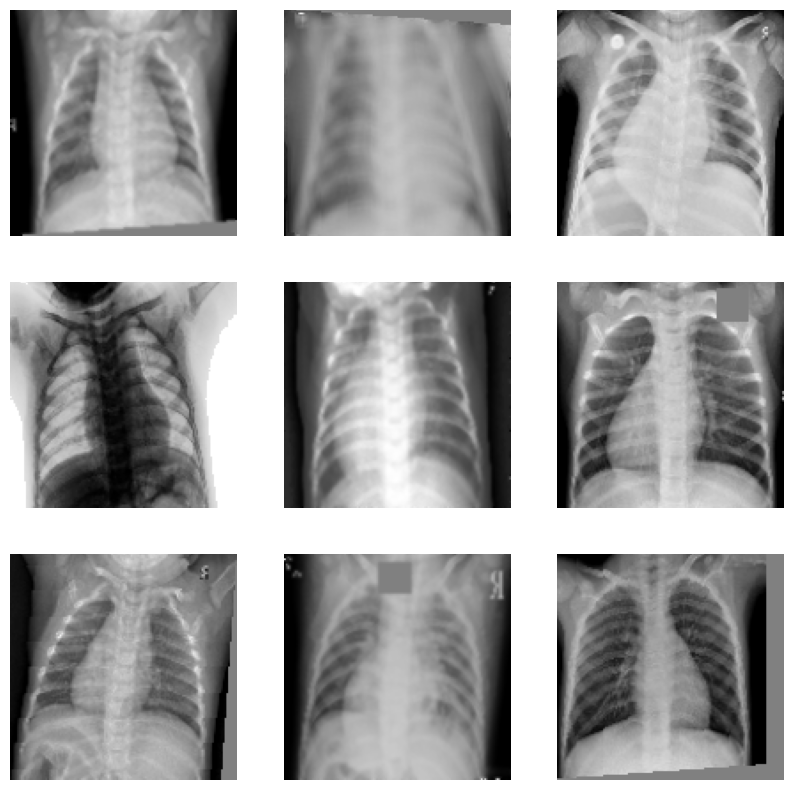

In [4]:
sample_images, _ = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [6]:
array = np.random.randint(0, 2, (9, 18))

In [7]:
array

array([[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]])

In [8]:
from src.Create_Model import create_model, model_summary
from src.Train_Model import train_model

test_model = create_model(model_array=array)
model_summary(test_model)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   208         ['rescaling[0][0]']       

In [1]:
test_model = train_model(train_ds, val_ds, test_model)

NameError: name 'train_model' is not defined

In [38]:
mask = np.random.randint(0, 2, (9, 18), dtype=np.bool_)

In [42]:
mask = mask = np.random.permutation(np.concatenate((np.zeros(9*18//2),
                                                 np.ones(9*18//2)))).reshape(9, 18).astype(np.bool_)

In [43]:
mask


array([[False, False,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True, False, False, False, False,  True,  True],
       [False, False, False,  True,  True, False, False, False, False,
         True, False, False,  True, False, False,  True, False,  True],
       [False,  True, False,  True, False,  True,  True,  True, False,
        False,  True, False, False, False, False,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True, False,  True, False,
         True, False,  True, False, False, False,  True,  True, False],
       [ True,  True,  True,  True,  True,  True, False, False,  True,
        False, False,  True, False,  True,  True, False,  True,  True],
       [ True, False,  True,  True, False, False, False,  True,  True,
         True, False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True, False, False, False,
        False, False,  True,  True,  True, False, False,  True,  True],

In [44]:
num_true = np.sum(mask)

In [45]:
num_true

81

In [53]:
array1 = np.random.randint(0, 2, (9, 18))
array2 = np.random.randint(0, 2, (9, 18))
next_g =  create_next_population(array1, array2, population=10)

In [54]:
next_g.shape


(10, 9, 18)